###
Compute the price of a European call option with the
Black-Scholes formula. The option has a strike price K of 105 and
expires in 2 years (T = 2). The initial price S0 of the underlying
stock equals 100, the risk-free interest rate, the volatility and the
dividend yield are respectively equal to r = 0.04, σ = 0.25 and
q = 0.05 per annum.

In [1]:
#imports
import numpy as np
from scipy.stats import norm
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#variables
K = 105
T = 2
S0 = 100
r = 0.04 
sigma = 0.25
q = 0.05


In [3]:
def black_scholes_price_EC(S0, K, r, q, sigma, T):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = np.exp(-q * T) * S0 * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    return call_price

EC_price = black_scholes_price_EC(S0, K, r, q, sigma, T)
print(f"European Call Option Price: {EC_price:.4f}")

European Call Option Price: 10.1721


In [4]:
#price a put options with same characteristics
def black_scholes_price_EP(S0, K, r, q, sigma, T):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = np.exp(-q * T) * S0 * norm.cdf(-d1) - np.exp(-r * T) * K * norm.cdf(-d2)
    return call_price

EP_price = black_scholes_price_EP(S0, K, r, q, sigma, T)
print(f"European Put Option Price: {EP_price:.4f}")

European Put Option Price: -16.6155


### Implied volatility
The implied volatility parameter, σ (K , T ), is equal to the
parameter that one needs to plug into the Black-Scholes formula
in order to match the model price with the given market price:
Model Price (σ (K , T )) = Market Price



In [5]:
# Read the data
path = "SP500_03_01_00.xls"
df_options = pd.read_excel(path, "option")
df_interest_rates = pd.read_excel(path, "interest_rate")
S0 = pd.read_excel(path, "stock")



In [6]:
# Extract the interest rate curve (assuming it is in two columns: time in days and rate)
interest_times = df_interest_rates.iloc[:, 0]  # Time in days
interest_rates = df_interest_rates.iloc[:, 1] / 100  # Interest rates in decimal form

In [7]:
# Convert time to maturity from days to years
df_options["T"] = df_options["T"] / 365  # Convert time to years
df_options['q'] = 0.00  # Example: setting a default dividend yield if it's missing
S0 = S0['price'].iloc[0]


In [8]:
# Convert time to maturity in years for interpolation
interest_times_years = interest_times / 365

# Create the cubic spline interpolator for the interest rate curve
interest_rate_spline = CubicSpline(interest_times_years, interest_rates)


# Function to compute interest rate for a given time to maturity
def get_interest_rate_for_option(T):
    return interest_rate_spline(T)  # Interpolates the rate for given time T in years

# Now, you can apply the function to find the interest rate for each option
df_options['r'] = df_options['T'].apply(get_interest_rate_for_option)

# Print the options dataframe to check if everything is correct
print(df_options.head())

          T     K  C_P_flag    price    q         r
0  0.052055  1025         1  0.16296  0.0  0.059175
1  0.052055  1050         1  0.25928  0.0  0.059175
2  0.052055  1075         1  0.48860  0.0  0.059175
3  0.052055  1100         1  0.48545  0.0  0.059175
4  0.052055  1125         1  0.52653  0.0  0.059175


In [9]:
def bs_price(S, K, T, r, sigma, q, option_type):
        # Black-Scholes formula (simplified for this example)
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        if option_type == 'call':
            price = np.exp(-q * T) * S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
        elif option_type == 'put':
            price = np.exp(-r * T) * K * norm.cdf(-d2) - np.exp(-q * T) * S * norm.cdf(-d1)
        return price

In [10]:
def implied_volatility(S, K, T, r, q, O, option_type):
    # Adjust the initial guess (x0) based on strike and maturity
    # For high strikes, initial guess increases; for long maturities, initial guess increases
    if K < S:
        initial_vol = 0.3  # Larger implied volatility for high strikes (OTM options)
    else:
        initial_vol = 0.1  # Lower implied volatility for low strikes (ITM options)

    # Use numerical optimization to find the volatility
    res = minimize(lambda sigma: (bs_price(S, K, T, r, sigma, q, option_type) - O)**2,
                   x0=initial_vol, bounds=[(1e-6, 5)])
    
    if res.success:
        return res.x[0]  # Return the implied volatility
    else:
        return np.nan  # Return NaN if optimization fails

In [11]:
# Apply implied volatility calculation to each row in the dataframe
df_options['IV'] = df_options.apply(
    lambda row: implied_volatility(
        S=S0,  # Initial stock price
        K=row['K'],  # Strike price
        T=row['T'],  # Time to maturity
        r=row['r'],  # Interest rate (from the previous step)
        q=row['q'],  # Dividend yield (add this to your data if necessary)
        O=row['price'],  # Market price of the option
        option_type='put' if row['C_P_flag'] == 1 else 'call'  # Option type: put if flag is 1, else call
    ), axis=1
)

# Print the dataframe with implied volatilities
print(df_options[['K', 'T', 'price', 'IV']].head(10))

      K         T    price        IV
0  1025  0.052055  0.16296  0.571815
1  1050  0.052055  0.25928  0.563055
2  1075  0.052055  0.48860  0.567142
3  1100  0.052055  0.48545  0.528462
4  1125  0.052055  0.52653  0.496030
5  1150  0.052055  0.90996  0.494787
6  1175  0.052055  0.98645  0.461272
7  1200  0.052055  1.14270  0.432164
8  1225  0.052055  1.37420  0.405165
9  1250  0.052055  1.83250  0.384750


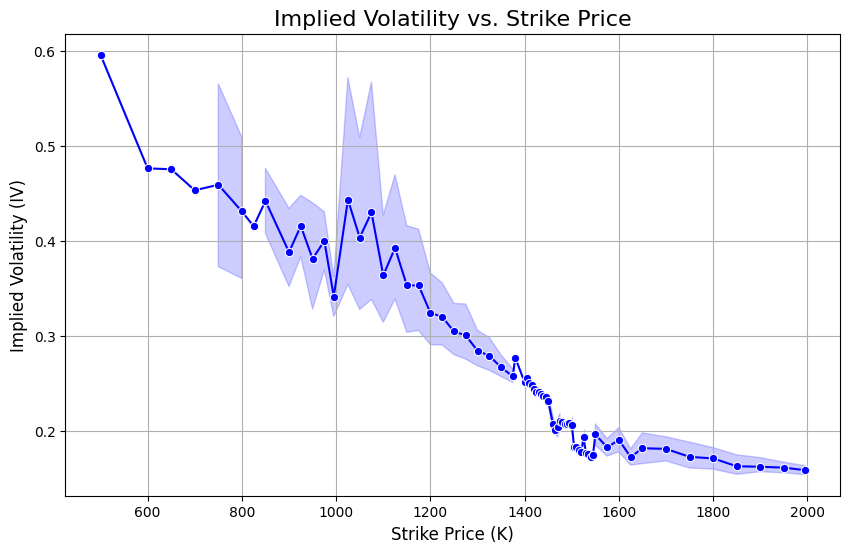

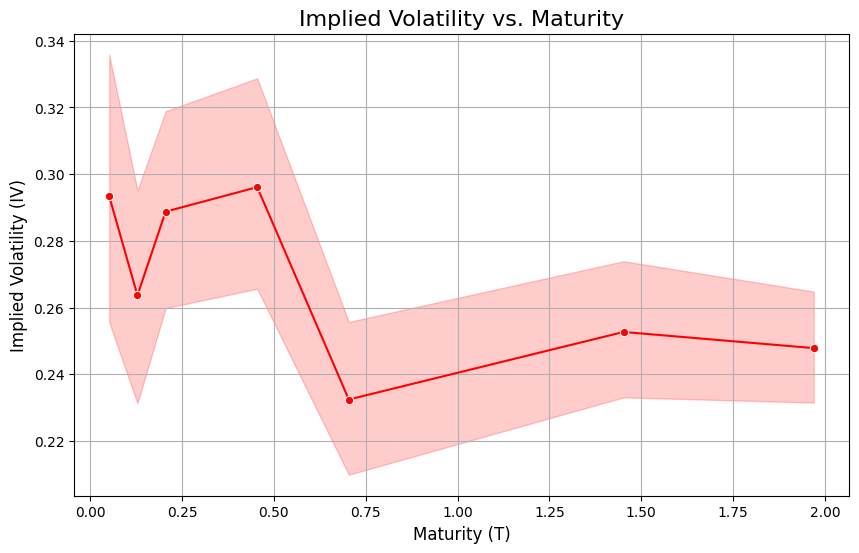

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Plotting Implied Volatility vs. Strike Price (K)
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_options['K'], y=df_options['IV'], marker='o', color='b')
plt.title('Implied Volatility vs. Strike Price', fontsize=16)
plt.xlabel('Strike Price (K)', fontsize=12)
plt.ylabel('Implied Volatility (IV)', fontsize=12)
plt.grid(True)
plt.show()

# Plotting Implied Volatility vs. Maturity (T)
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_options['T'], y=df_options['IV'], marker='o', color='r')
plt.title('Implied Volatility vs. Maturity', fontsize=16)
plt.xlabel('Maturity (T)', fontsize=12)
plt.ylabel('Implied Volatility (IV)', fontsize=12)
plt.grid(True)
plt.show()



K     0
T     0
IV    0
dtype: int64
IV_surface shape: (100, 100)
IV_surface values (sample): [[       nan        nan 0.52173681 0.25627847        nan]
 [       nan 0.42621285 0.33310902 0.2501232  0.16652889]
 [       nan 0.35980532 0.30493969 0.24368526 0.1797933 ]
 [       nan 0.35430954 0.29181351 0.24285513 0.18871702]
 [       nan        nan 0.28515696 0.24686658 0.19546797]]


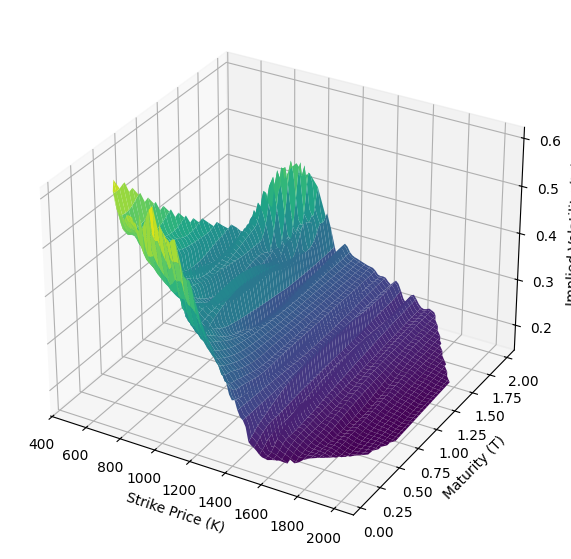

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Drop rows with NaN in 'IV' before interpolation
df_options_clean = df_options.dropna(subset=['IV'])

# Ensure no NaN values in your cleaned data
print(df_options_clean[['K', 'T', 'IV']].isna().sum())

# Example data: strike prices (K), maturities (T), and implied volatilities (IV)
K_values = df_options_clean['K']
T_values = df_options_clean['T']
IV_values = df_options_clean['IV']

# Create a grid for the interpolation (100 points along each axis)
K_grid, T_grid = np.meshgrid(np.linspace(min(K_values), max(K_values), 100),
                             np.linspace(min(T_values), max(T_values), 100))

# Stack K and T values into a 2D array (each pair of K, T forms a point)
points = np.vstack((K_values, T_values)).T

# Perform 2D interpolation using griddata
IV_surface = griddata(points, IV_values, (K_grid, T_grid), method='cubic')

# Check the shape of IV_surface to verify if the interpolation worked
print(f"IV_surface shape: {IV_surface.shape}")
print(f"IV_surface values (sample): {IV_surface[::20, ::20]}")  # Sample of values to see if interpolation worked

# Plot the smoothed implied volatility surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Check if the surface contains valid data
if np.all(np.isnan(IV_surface)):
    print("Warning: The interpolation resulted in NaN values.")
else:
    ax.plot_surface(K_grid, T_grid, IV_surface, cmap='viridis')

    # Add labels
    ax.set_xlabel('Strike Price (K)')
    ax.set_ylabel('Maturity (T)')
    ax.set_zlabel('Implied Volatility (IV)')

plt.show()


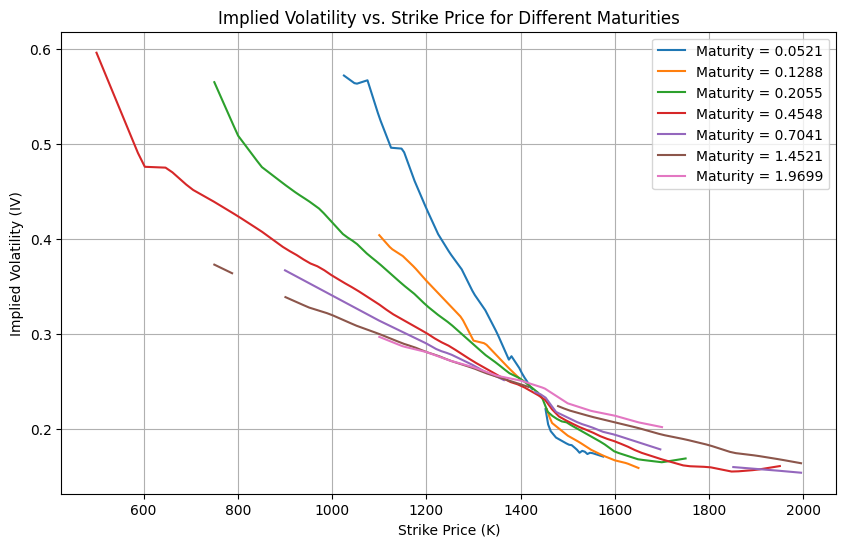

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Round the IV to 3 decimal places
df_options['IV'] = df_options['IV'].round(3)

# Create a plot
plt.figure(figsize=(10, 6))

# Iterate over the unique maturities (T)
for maturity in df_options['T'].unique():
    subset = df_options[df_options['T'] == maturity]

    # Interpolate missing IV values for each strike (K)
    # Sort by K to ensure interpolation works correctly
    subset = subset.sort_values('K')
    
    # Create an interpolation function based on K values
    interpolation_func = interp1d(subset['K'], subset['IV'], kind='linear', fill_value='extrapolate')
    
    # Generate a smooth K range for interpolation (optional: use original K range to avoid unnecessary interpolation)
    K_interp = np.linspace(subset['K'].min(), subset['K'].max(), 100)
    IV_interp = interpolation_func(K_interp)
    
    # Plot the interpolated IV values
    plt.plot(K_interp, IV_interp, label=f'Maturity = {round(maturity, 4)}')

# Add labels and title
plt.xlabel('Strike Price (K)')
plt.ylabel('Implied Volatility (IV)')
plt.title('Implied Volatility vs. Strike Price for Different Maturities')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


In [15]:
# Save the dataframe to an Excel file
df_options.to_excel("df_options.xlsx", index=False)

print("DataFrame saved to df_options.xlsx")

DataFrame saved to df_options.xlsx
